In [2]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

KeyboardInterrupt: 

In [ ]:
import zipfile

with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [3]:
import os
from pathlib import Path

path = Path('data/MRIs/')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

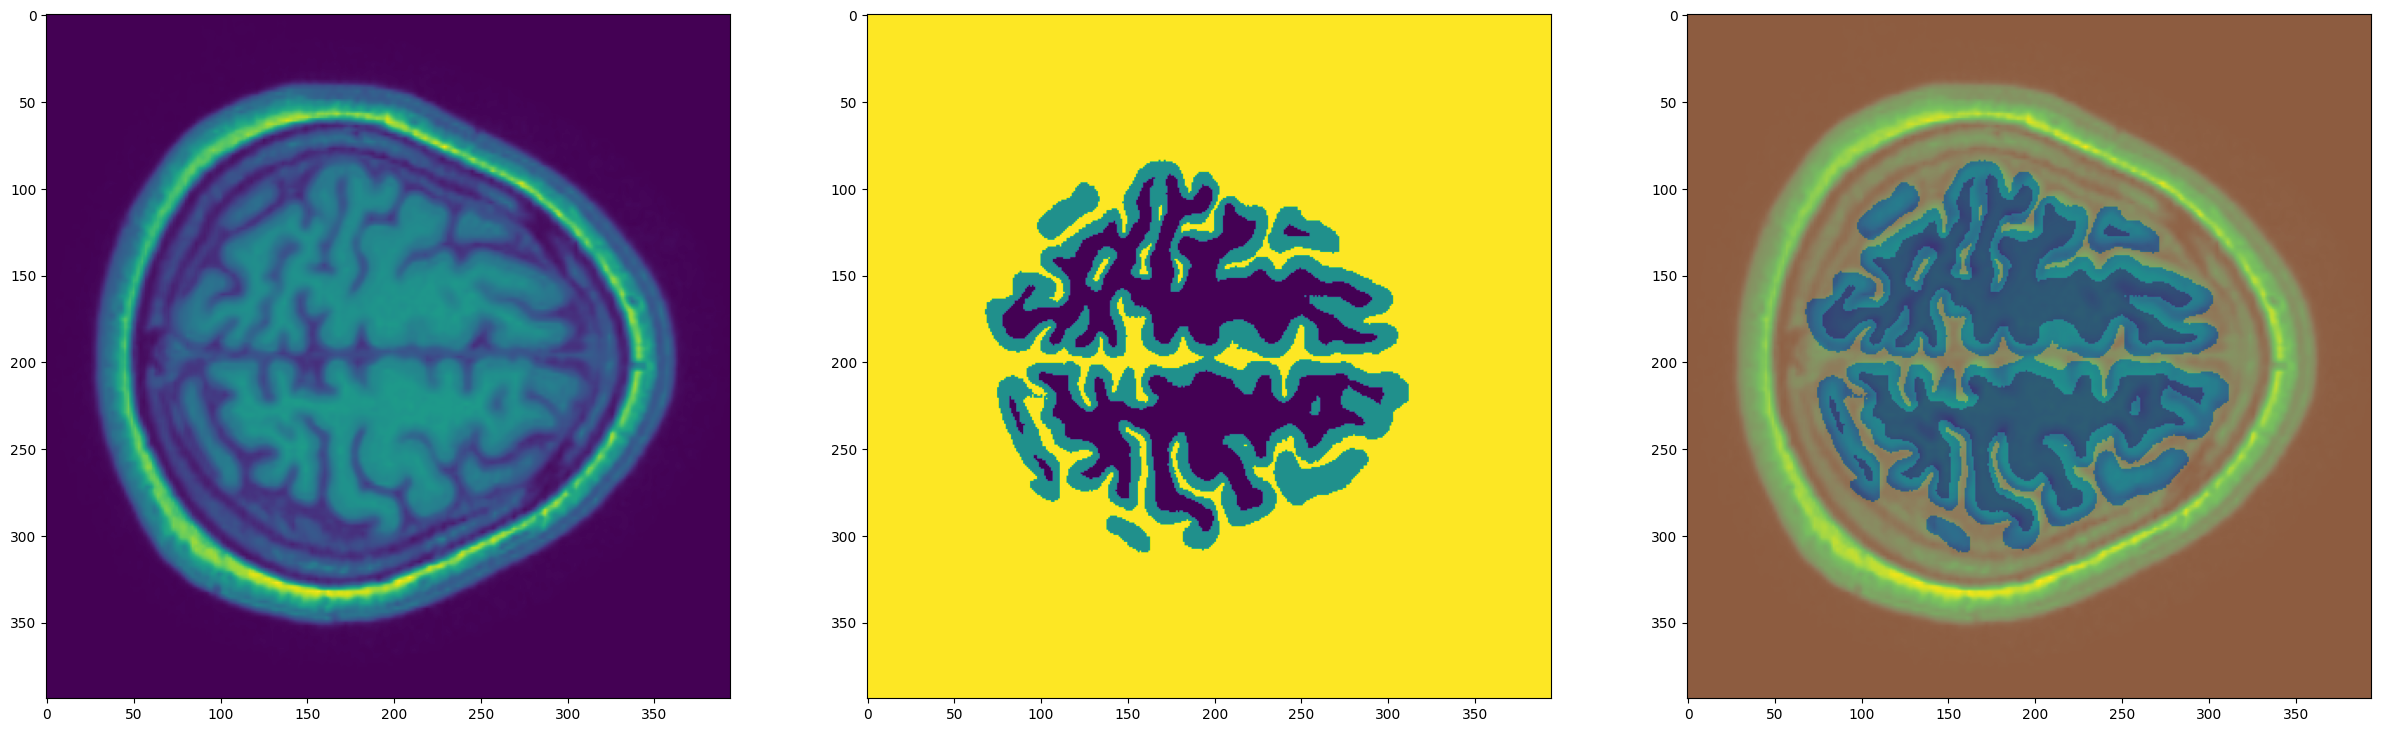

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [5]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.1462643, 0.00025629325)

In [6]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

In [7]:
mask_oh = (np.arange(3) == mask[..., None]).astype(np.float32)
mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

In [8]:
import torch
import torch.nn.functional as F

In [10]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


def enconder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co)
    )


class deconv(torch.nn.Module):
    def __init__(self, ci, co) -> None:
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [11]:
class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1) -> None:
        super().__init__()
        self.in_ch = in_ch

    
        c = [16, 32, 64, 128]

        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(self.in_ch, c[0]),
            conv3x3_bn(c[0], c[0])
        )

        self.conv2 = enconder_conv(c[0], c[1])
        self.conv3 = enconder_conv(c[1], c[2])
        self.conv4 = enconder_conv(c[2], c[3])

        self.deconv1 = deconv(c[3], c[2])
        self.deconv2 = deconv(c[2], c[1])
        self.deconv3 = deconv(c[1], c[0])

        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)
    

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)

        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [12]:
model = UNet()
output = model(torch.randn((10, 1, 394, 394)))
output.shape

torch.Size([10, 3, 394, 394])

In [30]:
def iou(outputs, labels):
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1):
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def fit(model, dataloader, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epoch} loss {loss.item():.5f} iou {ious:.5f}")

In [25]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)
img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [36]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/1 loss 0.18245 iou 0.81392
Epoch 2/2 loss 0.16520 iou 0.91452
Epoch 3/3 loss 0.16799 iou 0.88485
Epoch 4/4 loss 0.16290 iou 0.90764
Epoch 5/5 loss 0.15790 iou 0.92906
Epoch 6/6 loss 0.15535 iou 0.93136
Epoch 7/7 loss 0.15402 iou 0.92457
Epoch 8/8 loss 0.15211 iou 0.93043
Epoch 9/9 loss 0.15007 iou 0.93809
Epoch 10/10 loss 0.14800 iou 0.94277
Epoch 11/11 loss 0.14604 iou 0.94327
Epoch 12/12 loss 0.14440 iou 0.94269
Epoch 13/13 loss 0.14289 iou 0.94190
Epoch 14/14 loss 0.14121 iou 0.94570
Epoch 15/15 loss 0.13935 iou 0.95043
Epoch 16/16 loss 0.13744 iou 0.95561
Epoch 17/17 loss 0.13567 iou 0.95702
Epoch 18/18 loss 0.13417 iou 0.95624
Epoch 19/19 loss 0.13264 iou 0.95831
Epoch 20/20 loss 0.13111 iou 0.95948


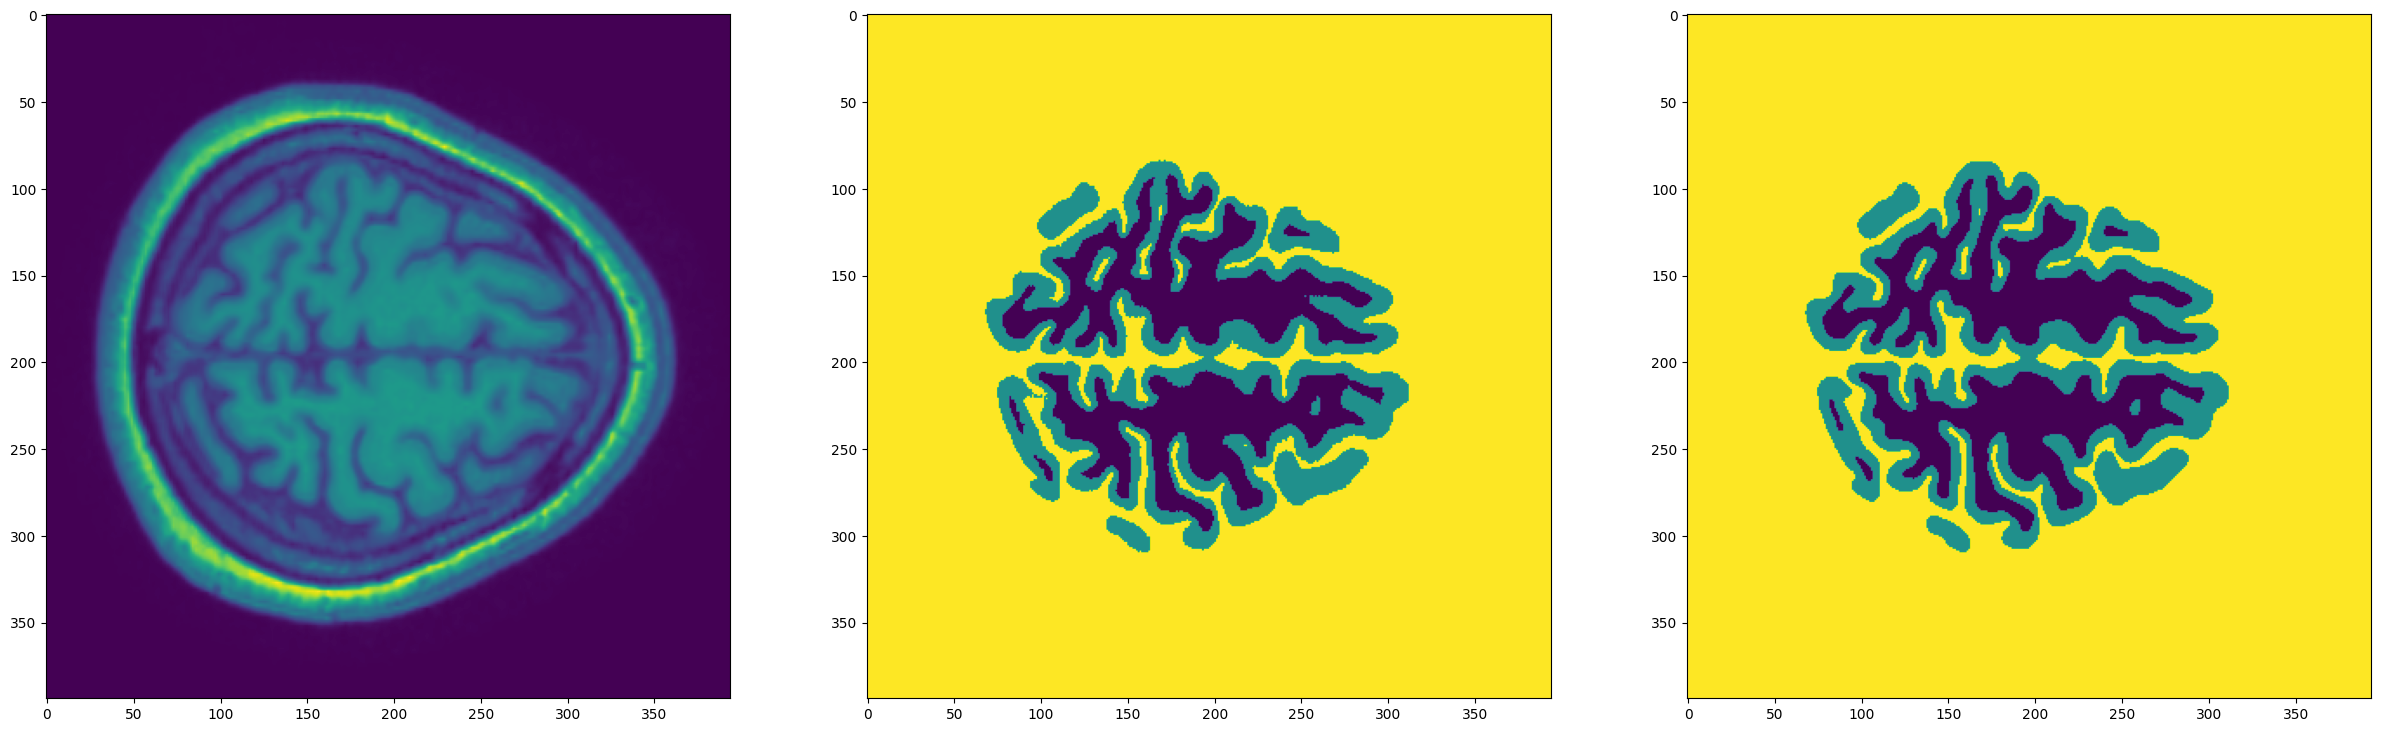

In [40]:
model.eval()

with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [41]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3) -> None:
        self.X = X
        self.y = y
        self.n_classes = n_classes

    
    def __len__(self):
        return len(self.X)

    
    def __getitem__(self, ix):
        img = np.load(self.X[ix])
        mask = np.load(self.y[ix])
        img = torch.tensor(img).unsqueeze(0)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)
        return img, torch.from_numpy(mask).permute(2,0,1)

In [42]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [43]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [45]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou':[], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [46]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.64042 test_iou 0.10521: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]



Epoch 1/30 loss 0.54103 iou 0.28869 test_loss 0.64042 test_iou 0.10521


test_loss 0.44819 test_iou 0.05683: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]



Epoch 2/30 loss 0.39483 iou 0.44333 test_loss 0.44819 test_iou 0.05683


test_loss 0.31083 test_iou 0.48326: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]



Epoch 3/30 loss 0.30440 iou 0.54557 test_loss 0.31083 test_iou 0.48326


test_loss 0.22042 test_iou 0.61483: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]



Epoch 4/30 loss 0.23929 iou 0.62171 test_loss 0.22042 test_iou 0.61483


test_loss 0.18932 test_iou 0.66467: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]



Epoch 5/30 loss 0.19531 iou 0.65628 test_loss 0.18932 test_iou 0.66467


test_loss 0.16066 test_iou 0.69449: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]



Epoch 6/30 loss 0.16437 iou 0.68083 test_loss 0.16066 test_iou 0.69449


test_loss 0.13716 test_iou 0.69826: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]



Epoch 7/30 loss 0.14311 iou 0.69630 test_loss 0.13716 test_iou 0.69826


test_loss 0.12541 test_iou 0.70648: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]



Epoch 8/30 loss 0.12757 iou 0.70753 test_loss 0.12541 test_iou 0.70648


test_loss 0.11825 test_iou 0.70099: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]



Epoch 9/30 loss 0.11602 iou 0.71475 test_loss 0.11825 test_iou 0.70099


test_loss 0.12351 test_iou 0.63860: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]



Epoch 10/30 loss 0.10732 iou 0.72161 test_loss 0.12351 test_iou 0.63860


test_loss 0.10013 test_iou 0.71827: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]



Epoch 11/30 loss 0.10128 iou 0.72240 test_loss 0.10013 test_iou 0.71827


test_loss 0.09440 test_iou 0.72961: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]



Epoch 12/30 loss 0.09561 iou 0.72932 test_loss 0.09440 test_iou 0.72961


test_loss 0.09827 test_iou 0.68336: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]



Epoch 13/30 loss 0.09008 iou 0.73393 test_loss 0.09827 test_iou 0.68336


test_loss 0.08737 test_iou 0.73416: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]



Epoch 14/30 loss 0.08454 iou 0.74545 test_loss 0.08737 test_iou 0.73416


test_loss 0.08372 test_iou 0.73783: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]



Epoch 15/30 loss 0.08091 iou 0.74909 test_loss 0.08372 test_iou 0.73783


test_loss 0.08423 test_iou 0.73977: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]



Epoch 16/30 loss 0.07698 iou 0.75624 test_loss 0.08423 test_iou 0.73977


test_loss 0.07978 test_iou 0.73929: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]



Epoch 17/30 loss 0.07605 iou 0.75205 test_loss 0.07978 test_iou 0.73929


test_loss 0.07815 test_iou 0.73295: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]



Epoch 18/30 loss 0.07231 iou 0.76041 test_loss 0.07815 test_iou 0.73295


test_loss 0.07472 test_iou 0.75296: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]



Epoch 19/30 loss 0.06969 iou 0.76558 test_loss 0.07472 test_iou 0.75296


test_loss 0.07470 test_iou 0.74267: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]



Epoch 20/30 loss 0.06696 iou 0.77178 test_loss 0.07470 test_iou 0.74267


test_loss 0.07531 test_iou 0.73568: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]



Epoch 21/30 loss 0.06548 iou 0.77392 test_loss 0.07531 test_iou 0.73568


test_loss 0.07310 test_iou 0.74725: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]



Epoch 22/30 loss 0.06409 iou 0.77578 test_loss 0.07310 test_iou 0.74725


test_loss 0.06815 test_iou 0.76049: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]



Epoch 23/30 loss 0.06233 iou 0.77868 test_loss 0.06815 test_iou 0.76049


test_loss 0.06889 test_iou 0.75600: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]



Epoch 24/30 loss 0.05999 iou 0.78511 test_loss 0.06889 test_iou 0.75600


test_loss 0.07683 test_iou 0.71573: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]



Epoch 25/30 loss 0.05845 iou 0.78771 test_loss 0.07683 test_iou 0.71573


test_loss 0.07229 test_iou 0.73419: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]



Epoch 26/30 loss 0.06011 iou 0.77935 test_loss 0.07229 test_iou 0.73419


test_loss 0.06962 test_iou 0.75536: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]



Epoch 27/30 loss 0.05846 iou 0.78364 test_loss 0.06962 test_iou 0.75536


test_loss 0.06581 test_iou 0.75804: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]



Epoch 28/30 loss 0.05525 iou 0.79440 test_loss 0.06581 test_iou 0.75804


test_loss 0.06498 test_iou 0.75968: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]



Epoch 29/30 loss 0.05502 iou 0.79276 test_loss 0.06498 test_iou 0.75968


test_loss 0.07001 test_iou 0.73246: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch 30/30 loss 0.05280 iou 0.80129 test_loss 0.07001 test_iou 0.73246


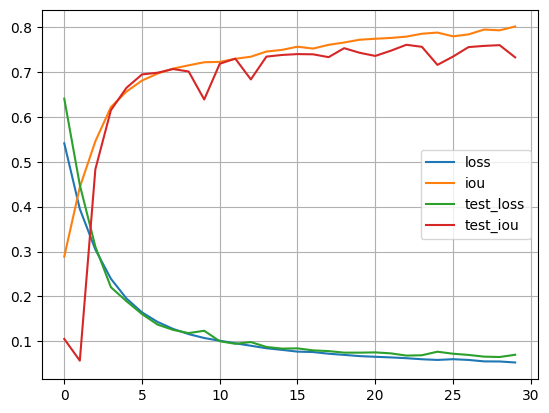

In [48]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()